In [1]:
# Parte 1: Preparación del entorno
#!pip install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



   Product ID                                      Product Title  \
0           1                    apple iphone 8 plus 64gb silver   
1           2                apple iphone 8 plus 64 gb spacegrau   
2           3  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...   
3           4                apple iphone 8 plus 64gb space grey   
4           5  apple iphone 8 plus gold 5.5 64gb 4g unlocked ...   

    Merchant ID   Cluster ID             Cluster Label   Category ID  \
0             1            1  Apple iPhone 8 Plus 64GB          2612   
1             2            1  Apple iPhone 8 Plus 64GB          2612   
2             3            1  Apple iPhone 8 Plus 64GB          2612   
3             4            1  Apple iPhone 8 Plus 64GB          2612   
4             5            1  Apple iPhone 8 Plus 64GB          2612   

   Category Label  
0   Mobile Phones  
1   Mobile Phones  
2   Mobile Phones  
3   Mobile Phones  
4   Mobile Phones  
<class 'pandas.core.frame.DataFrame'>


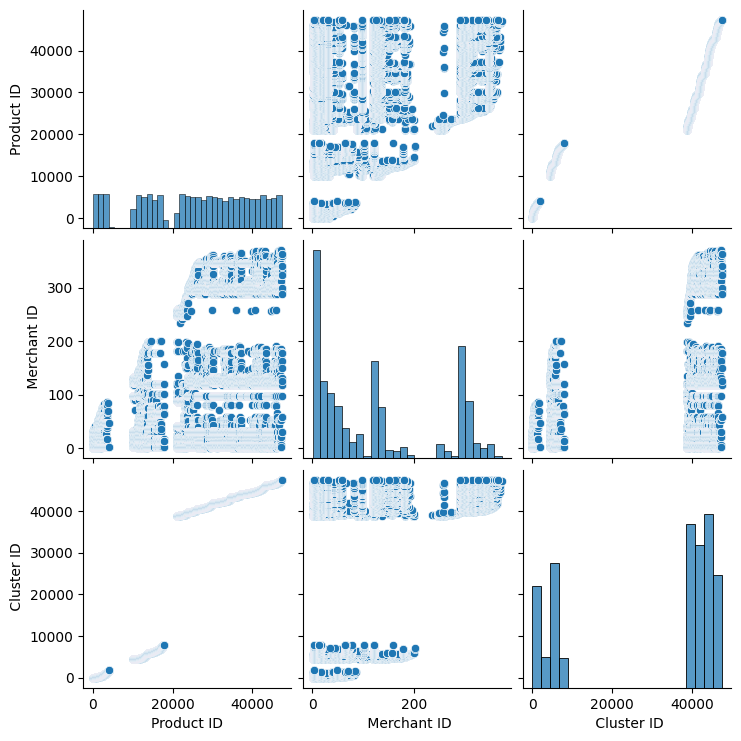

In [2]:
# Parte 2: Carga y análisis exploratorio de los datos
df = pd.read_csv('pricerunner_aggregate.csv')

print(df.head())
print(df.info())
print(df.describe())

# Visualización de la distribución
#Vamos a utilizar solo campos numéricos para que la visualización con sns.pairplot, sean óptimas.
#Cada fila representa una oferta de un producto por parte de un comerciante.
# Product ID   int64 Identificador del Producto
# Merchant ID	int64	Identificador del comerciante
# Cluster ID	  int64	ID del grupo/cluster asignado al producto
# Category ID	int64	ID de categoría del producto

#Es útil para visualizar relaciones entre variables numéricas y detectar agrupaciones o patrones.

sns.pairplot(df[['Product ID', ' Merchant ID', ' Cluster ID']])
plt.show()


**¿Por qué es necesario escalar para K-Means y DBSCAN?**

Ambos algoritmos usan distancias (por ejemplo, distancia euclidiana) para agrupar los datos. Si una variable tiene un rango mucho mayor que otra, dominará la distancia total y, por lo tanto, tendrá más peso en la decisión del algoritmo, aunque no necesariamente sea más importante.

Se debe escalar, para que cada variable tenga media 0 y desviación estándar 1. influirá más en el cálculo de distancias simplemente porque sus valores son más grandes.

In [3]:
# Parte 3: Preprocesamiento
X = df[['Product ID', ' Merchant ID', ' Cluster ID',
                  ' Category ID']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

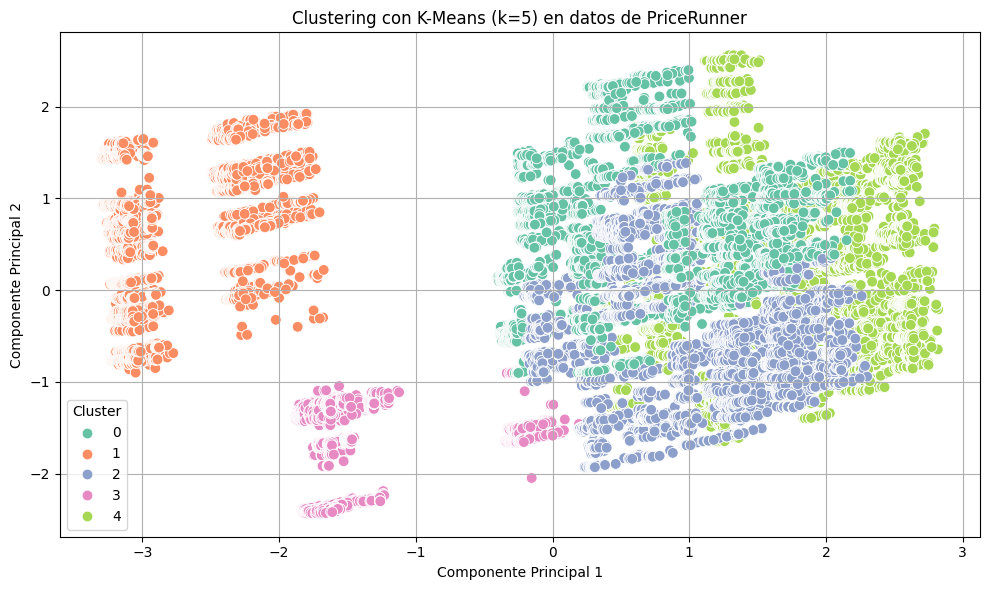

In [4]:

# Seleccionar columnas relevantes
columns_to_use = ['Product ID', ' Merchant ID', ' Cluster ID', ' Cluster Label',
                  ' Category ID', ' Category Label']

# Copiar solo esas columnas
df_subset = df[columns_to_use].copy()

# Convertir columnas categóricas a números
label_encoders = {}
for col in [' Cluster Label', ' Category Label']:
    le = LabelEncoder()
    df_subset[col] = le.fit_transform(df_subset[col].astype(str))
    label_encoders[col] = le

# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_subset)

# Aplicar KMEANS.
#El parámetro n_clusters=5 indica que queremos agrupar los datos en 5 clusters (grupos).
#¿Por qué se elige 5 clusters?
#Esta elección puede depender de varios factores:
#1. Elección arbitraria para exploración inicial
#   A veces se empieza con 5 como una estimación tentativa para observar cómo se comportan los datos, especialmente si no se tiene conocimiento previo del número óptimo de grupos.
#2. Basado en conocimiento previo
#   Si conoces de antemano que hay 5 tipos de productos, categorías o segmentos, entonces tiene sentido agrupar en 5 clusters.
#3. Parte de un proceso de experimentación
    #Puede que estés comparando varios valores de k (por ejemplo, de 2 a 10) usando métodos como:
    #Elbow method (método del codo): busca el punto donde añadir más clusters no mejora significativamente la varianza explicada.
#4. n_init=10
    #Este valor especifica cuántas veces se ejecutará el algoritmo con diferentes centroides iniciales. Luego, se elige la mejor agrupación (la de menor inercia). Esto ayuda a evitar malas soluciones por malas inicializaciones.

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

# Reducir dimensiones para visualización
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Graficar los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette='Set2', s=60)
plt.title('Clustering con K-Means (k=5) en datos de PriceRunner')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


**¿Qué es K-Means Clustering?**

Es un algoritmo no supervisado que divide los datos en K grupos (clusters) con base en la distancia entre puntos. Cada grupo se forma alrededor de un centroide. El objetivo es minimizar la distancia total entre los puntos y su centroide.

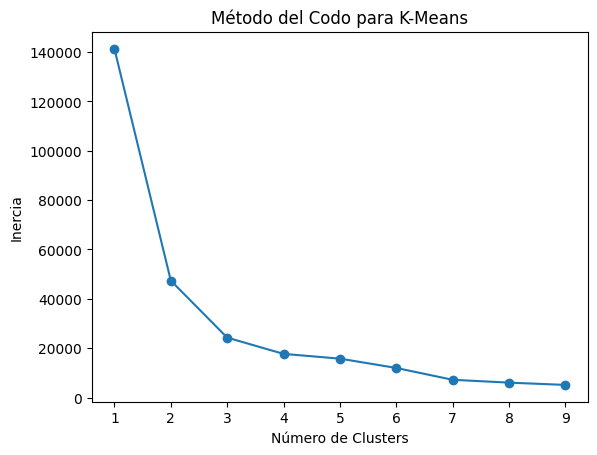

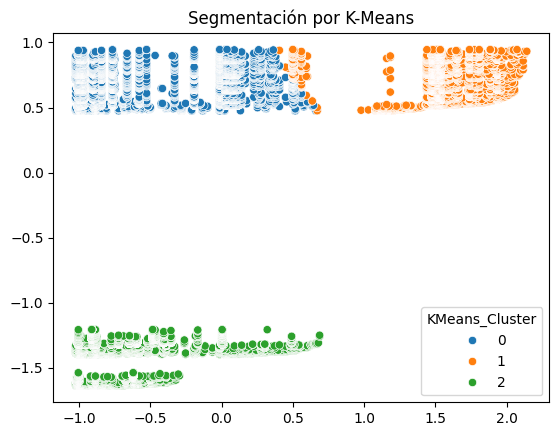

In [5]:
# Parte 4.1: Clustering con K-Means
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Método del Codo
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Número de Clusters') # Numero de grupos
plt.ylabel('Inercia') # la suma de las distancias cuadradas de cada punto a su centroide (cuánto error hay dentro de cada cluster).
plt.title('Método del Codo para K-Means')
plt.show()

# Ajuste del modelo con K óptimo 3) SE AJUSTA EL MODELO A K ÓPTIMO 3
kmeans = KMeans(n_clusters=3, random_state=42)
# This line creates the 'KMeans_Cluster' column in the DataFrame df
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['KMeans_Cluster'], palette='tab10')
plt.title('Segmentación por K-Means')
plt.show()

In [6]:
# Parte 4.1.1: Interpretación de Clustering con K-Means
#¿Qué significa esto?
# cluster agrupa productos con ciertas características similares:
# El Cluster 2, tiene valores promedio de Product ID y Cluster ID mucho más bajos. Podría representar productos de
# otra categoría o segmento completamente diferente.
# El Cluster 1 tiene un valor alto en Merchant ID, lo cual puede indicar que está compuesto por productos vendidos por ciertos comerciantes grandes o específicos.
# Las diferencias en Category ID y Cluster ID también reflejan cómo se agrupan productos similares.

## SE LOGRÓ LA SEPARACIÓN ? ##
# Sí. Los valores promedio en cada cluster son claramente distintos, especialmente en Product ID, #Cluster ID y Merchant ID,
# lo que indica que el modelo sí logró encontrar patrones de agrupación.

df.groupby('KMeans_Cluster')[['Product ID', ' Merchant ID', ' Cluster ID',
                  ' Category ID']].mean()


,Product ID,Merchant ID,Cluster ID,Category ID
KMeans_Cluster,,,,
0,33165.275477,63.920675,42492.218598,2620.142339
1,35496.453690,298.046099,43241.009304,2620.605308
2,9724.203007,45.113062,3882.128878,2613.626314


¿Qué es DBSCAN?

DBSCAN es un algoritmo de clustering basado en densidad. A diferencia de K-Means (que requiere que definas el número de clusters k), DBSCAN:

* Encuentra agrupaciones densas de puntos sin necesidad de saber cuántos clusters hay.

* Identifica automáticamente "ruido" o "outliers", etiquetándolos como -1.

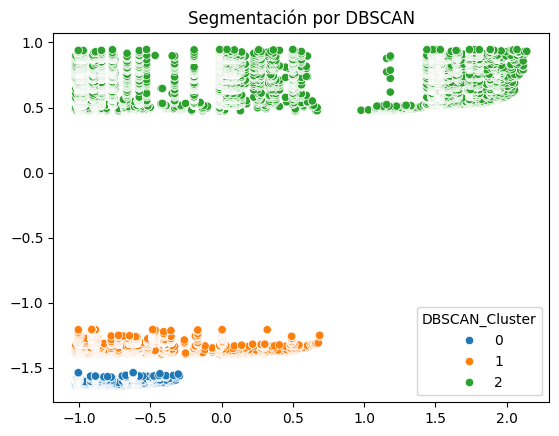

In [7]:
# Parte 4.2: Clustering con DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=5) # eps = radio máximo para considerar que dos puntos están “cerca”./ min_samples =  número mínimo de puntos vecinos necesarios para formar un cluster.
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['DBSCAN_Cluster'], palette='tab10')
plt.title('Segmentación por DBSCAN')
plt.show()


In [8]:
# Parte 4.2.1: Interpretando los Clustering con DBSCAN
df['DBSCAN_Cluster'].value_counts()
df.groupby('DBSCAN_Cluster')[['Product ID',' Merchant ID', ' Cluster ID', ' Category ID']].mean()





,Product ID,Merchant ID,Cluster ID,Category ID
DBSCAN_Cluster,,,,
0,2045.504043,22.905415,544.582210,2612.000000
1,13944.075141,57.317398,5716.296391,2614.520065
2,34091.518274,156.945303,42789.734246,2620.326290


In [9]:
# Parte 4.2.2: Interpretando los Clustering con DBSCAN sin atípicos
df_no_noise = df[df['DBSCAN_Cluster'] != -1]
df_no_noise.groupby('DBSCAN_Cluster')[['Product ID',' Merchant ID', ' Cluster ID', ' Category ID']].mean()

,Product ID,Merchant ID,Cluster ID,Category ID
DBSCAN_Cluster,,,,
0,2045.504043,22.905415,544.582210,2612.000000
1,13944.075141,57.317398,5716.296391,2614.520065
2,34091.518274,156.945303,42789.734246,2620.326290


**¿Qué es PCA?**

PCA (Principal Component Analysis) es una técnica matemática que:

* Reduce el número de variables (dimensiones) de un dataset.

* Conserva la mayor parte de la variabilidad (información) de los datos originales.

* Transforma los datos a componentes principales que son combinaciones lineales de las variables originales.

¿Qué significa reducir de 3 a 2 dimensiones?

Reduces de:

Tres variables originales (PRODUCT, MARCHANT, CLUSTER, CATEGORY)

a:

Dos nuevas variables artificiales, llamadas Componentes principales: PC1 y PC2.

Cada una de estas componentes es una combinación lineal de las variables originales. Por ejemplo:



* PC1=0.5⋅MARCHANT+0.7⋅CLUSTER+0.5⋅CATEGORY
* PC2=−0.6⋅MARCHANT+0.4⋅CLUSTER+0.7⋅CATEGORY

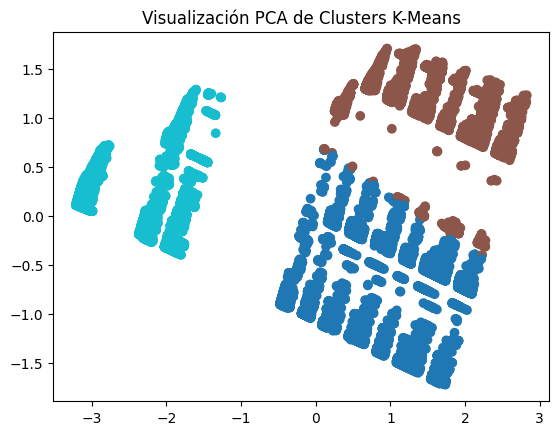

In [12]:
# Parte 5.1: Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['KMeans_Cluster'], cmap='tab10')
plt.title('Visualización PCA de Clusters K-Means')
plt.show()


In [67]:
# Parte 5.1.1: Interpretación de Reducción de dimensionalidad con PCA
df.groupby('KMeans_Cluster')[['Product ID',' Merchant ID', ' Cluster ID', ' Category ID']].mean()


,Product ID,Merchant ID,Cluster ID,Category ID
KMeans_Cluster,,,,
0,33165.275477,63.920675,42492.218598,2620.142339
1,35496.453690,298.046099,43241.009304,2620.605308
2,9724.203007,45.113062,3882.128878,2613.626314


In [17]:
# Parte 5.1.2: Interpretación detallada de Reducción de dimensionalidad con PCA
# Mostrar algunos Productos por cluster
for i in range(3):     ## Porque KMeans se entrenó con 3 clusters. K=3
    print(f"\nCluster {i}")
    display(df[df['KMeans_Cluster'] == i][['Product ID',' Merchant ID', ' Cluster ID', ' Category ID']].head())



Cluster 0


,Product ID,Merchant ID,Cluster ID,Category ID
11509,21065,17,38848,2617
11510,21066,4,38848,2617
11512,21068,41,38848,2617
11513,21069,88,38848,2617
11515,21071,7,38848,2617



Cluster 1


,Product ID,Merchant ID,Cluster ID,Category ID
11507,21063,247,38848,2617
11508,21064,248,38848,2617
11511,21067,249,38848,2617
11514,21070,250,38848,2617
11516,21072,251,38848,2617



Cluster 2


,Product ID,Merchant ID,Cluster ID,Category ID
0,1,1,1,2612
1,2,2,1,2612
2,3,3,1,2612
3,4,4,1,2612
4,5,5,1,2612


**Interpretación del Cluster 0, después de haber reducido los datos con PCA, para facilitar la visualización y mejorar el rendimiento.**

Todos los productos pertenecen a la misma categoría (Category ID 2617) y mismo Cluster ID real (38848), pero provienen de diferentes comerciantes (Merchant ID) y productos distintos.

El modelo los agrupó juntos (Cluster 0), posiblemente porque comparten muchas características similares tras la reducción dimensional con PCA.

**¿Qué es t-SNE?**

t-SNE es una técnica de reducción de dimensionalidad no lineal diseñada específicamente para visualización de datos complejos en 2D o 3D.

A diferencia de PCA (que usa combinaciones lineales de variables para preservar la varianza), t-SNE preserva la estructura local de los datos. Es decir:

Los puntos que estaban cerca en el espacio original seguirán cerca en el nuevo espacio 2D.


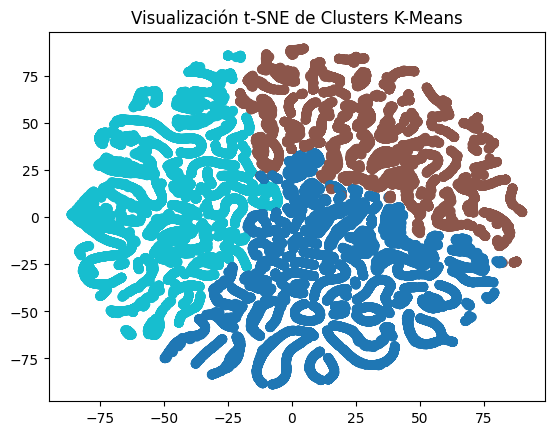

In [18]:
# Parte 5.2: Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42) # cuántos vecinos cercanos considera t-SNE / cuánto se mueven los puntos
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['KMeans_Cluster'], cmap='tab10')
plt.title('Visualización t-SNE de Clusters K-Means')
plt.show()


**Interpretación práctica del gráfico t_SNE de Cluster K-Means.**

Se Observa:
Tres grupos compactos de colores bien definidos (café, verde y azul), cada uno separado visualmente, significa que los clusters formados tienen sentido, y los productos dentro de cada grupo tienen patrones similares y que K = 3 fue una buena elección.

El gráfico t-SNE es una herramienta visual de validación para ver si el clustering con K-Means tiene sentido geométrico en un espacio de menor dimensión. Si ves separación clara por colores, es una señal fuerte de que los clusters reflejan estructuras reales en los datos.

In [19]:
# Parte 5.2.1: Interpretación de Reducción de dimensionalidad con t-SNE
df.groupby('KMeans_Cluster')[['Product ID',' Merchant ID', ' Cluster ID', ' Category ID']].mean()


,Product ID,Merchant ID,Cluster ID,Category ID
KMeans_Cluster,,,,
0,33165.275477,63.920675,42492.218598,2620.142339
1,35496.453690,298.046099,43241.009304,2620.605308
2,9724.203007,45.113062,3882.128878,2613.626314


**Cluster 0:**
Productos de categoría 2620, con Product ID alto.
Pertenecen a un Cluster ID elevado, y son ofrecidos por comerciantes medianos.
**Interpretación:** Podrían ser productos populares o de consumo masivo, en comercios conocidos, pero no grandes.

**Cluster 1:**
También en categoría 2620, pero con Merchant ID más alto (comercio más relevante).
Cluster ID alto → gran variedad.
Interpretación: Productos similares a Cluster 0, pero en comercios más grandes o con más alcance.

**Cluster 2:**
Category ID diferente (2613), Product ID bajo, y menor presencia de comercio.
Interpretación: Productos distintos, probablemente más antiguos o de nicho, vendidos por comercios más pequeños.

In [20]:
# Parte 6: Análisis
print("Clusters únicos KMeans:", df['KMeans_Cluster'].unique())
print("Clusters únicos DBSCAN:", df['DBSCAN_Cluster'].unique())


Clusters únicos KMeans: [2 1 0]
Clusters únicos DBSCAN: [0 1 2]


In [21]:
pd.crosstab(df['KMeans_Cluster'], df['DBSCAN_Cluster'])

DBSCAN_Cluster,0,1,2
KMeans_Cluster,,,
0,0,0,14346
1,0,0,9458
2,4081,7426,0


**Análisis Final:**

KMeans_Cluster 0 y 1 coinciden completamente con DBSCAN_Cluster 2.
Es decir, todos los puntos que K-Means agrupó en los clusters 0 y 1, DBSCAN los agrupó en el mismo cluster (2).
Esto sugiere que DBSCAN ve estos dos grupos como parte de un mismo conjunto denso o núcleo de datos.

KMeans_Cluster 2 fue dividido por DBSCAN en dos grupos:
4,081 puntos en DBSCAN_Cluster 0
7,426 puntos en DBSCAN_Cluster 1

Esto indica que KMeans metió todo ese grupo en un solo "saco", pero DBSCAN identificó dos subgrupos estructuralmente diferentes, lo que es una señal de que DBSCAN detecta mejor la forma y densidad de los datos, especialmente en clusters no esféricos o con diferente densidad.